<a href="https://colab.research.google.com/github/nkehle/Personal-Projects/blob/main/Chest_Xray_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)

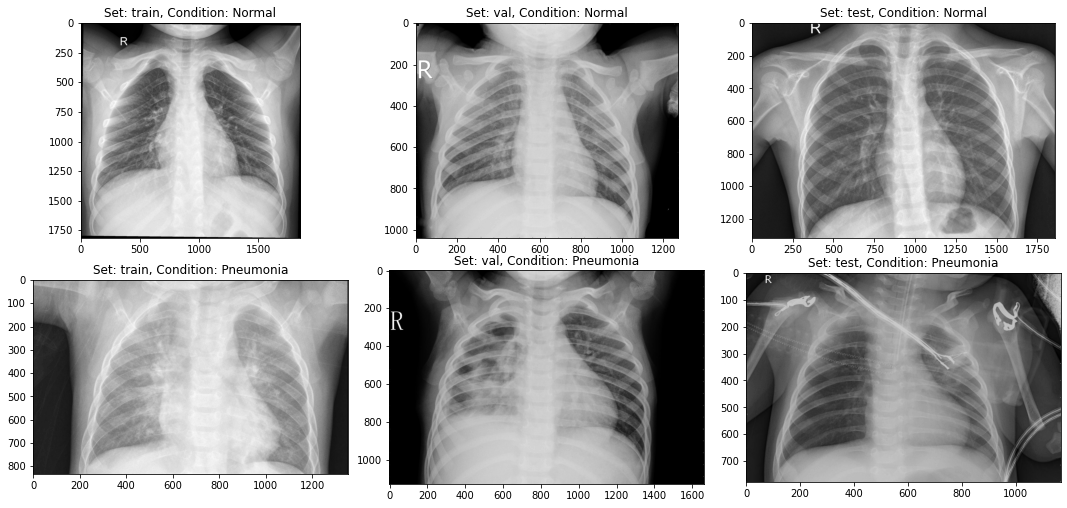

In [26]:
input_path = 'chest_xray/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [29]:
for _set in ['train', 'val', 'test']:
  n_normal = len(os.listdir('chest_xray/' + _set + '/NORMAL'))
  n_infect = len(os.listdir('chest_xray/' + _set + '/PNEUMONIA'))
  print('Set: {}, normal images: {}, pneumnia images: {}'. format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumnia images: 3875
Set: val, normal images: 8, pneumnia images: 8
Set: test, normal images: 234, pneumnia images: 390


In [39]:
def process_data(img_dims, batch_size):
  # gen objects
  train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,
  vertical_flip=True)
  test_val_datagen = ImageDataGenerator(rescale = 1./255)

  #feed batches
  train_gen = train_datagen.flow_from_directory(
    directory = 'chest_xray/'+'train', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)

  test_gen = test_val_datagen.flow_from_directory(
    directory = 'chest_xray/'+'test', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)

  test_data = []
  test_labels = []

  for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir('chest_xray/' + 'test' + cond)):
      img = plt.imread('chest_xray/'+'test'+cond+img)
      img = cv2.resize(img, (img_dims, img_dims))
      img = np.dstack([img, img, img])
      img = img.astype('float32') / 255
      if cond == '/NORMAL/':
          label = 0
      elif cond == '/PNEUMONIA/':
          label = 1
      test_data.append(img)
      test_labels.append(label)
  
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels    

In [40]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [41]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [42]:
hist = model.fit_generator(
  train_gen, steps_per_epoch=train_gen.samples // batch_size, 
  epochs=epochs, validation_data=test_gen, 
  validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-42-3b046ddcdba2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 370s 2s/step - loss: 0.3774 - accuracy: 0.8217 - val_loss: 0.7356 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 358s 2s/step - loss: 0.2857 - accuracy: 0.8754 - val_loss: 0.6592 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8825
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 357s 2s/step - loss: 0.2856 - accuracy: 0.8825 - val_loss: 0.7017 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 361s 2s/step - loss: 0.2266 - accuracy: 0.9133 - val_loss: 0.8117 - val_accuracy: 0.4013 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 358s 2s/step - loss: 0.2148 - accuracy: 0.9201 - val_loss: 0.9709 - val_accuracy: 0.6316 - lr: 3.0000e-04
Epoch 6/10
163/163 [==============================]

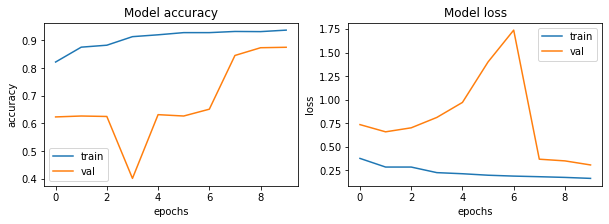

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

8/8 [==============================] - 5s 549ms/step
CONFUSION MATRIX ------------------
[[210  24]
 [  0   0]]

TEST METRICS ----------------------
Accuracy: 89.74358974358975%
Precision: 0.0%
Recall: nan%
F1-score: nan

TRAIN METRIC ----------------------
Train acc: 93.69


<ipython-input-46-77981f955e2d>:14: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp/(tp+fn)*100
